In [1]:
# Imports necessary to acquire, prepare, explore, visualize, analyze, and model data

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import env
import acquire
import prepare 

from tabulate import tabulate
from IPython.display import Markdown, display

from math import sqrt
from scipy import stats

import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr, spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.impute import SimpleImputer

np.random.seed(123)

In [2]:
df = acquire.get_zillow_data()

In [3]:
df = prepare.remove_outliers(df)

In [4]:
df = prepare.handle_nulls(df)

In [5]:
df = prepare.rename_columns(df)

In [6]:
df = prepare.prepare_locs(df)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47936 entries, 0 to 52440
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   parcelid                   47936 non-null  int64         
 1   bathrooms                  47936 non-null  float64       
 2   bedrooms                   47936 non-null  float64       
 3   square_feet                47936 non-null  int64         
 4   fips                       47936 non-null  int64         
 5   garages                    47936 non-null  int64         
 6   garage_size                47936 non-null  int64         
 7   lot_size                   47936 non-null  int64         
 8   has_pool                   47936 non-null  bool          
 9   propertycountylandusecode  47936 non-null  object        
 10  propertylandusetypeid      47936 non-null  float64       
 11  year_built                 47936 non-null  int64         
 12  log_

In [8]:
train, test = train_test_split(df, test_size=.2, random_state=123)
train, validate = train_test_split(train, test_size=.3, random_state=123)
# Splits data into 3 subsets: train, validate, test. Random state specifying that data is split
# with the exact same records when the code is re-run (useful for exploration and modeling, yet
# I suggest dropping this when employing the model)

def printmd(string): # function to format text style
    display(Markdown(string))
print()
printmd('**Number of Train Records:** {:,}'
     .format(len(train)))
printmd('**Number of Validate Records:** {:,}'
     .format(len(validate)))
printmd('**Number of Test Records:** {:,}'
     .format(len(test)))
# returns the amount of records in each subset after splitting

**Number of Train Records:** 26,843

**Number of Validate Records:** 11,505

**Number of Test Records:** 9,588

In [9]:
orange_train = train.where(train.county == 'orange')
orange_validate = validate.where(validate.county == 'orange')
orange_test = test.where(test.county == 'orange')

In [10]:
orange_train = orange_train.dropna()
orange_validate = orange_validate.dropna()
orange_test = orange_test.dropna()

In [11]:
orange_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7368 entries, 50705 to 1588
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   parcelid                   7368 non-null   float64       
 1   bathrooms                  7368 non-null   float64       
 2   bedrooms                   7368 non-null   float64       
 3   square_feet                7368 non-null   float64       
 4   fips                       7368 non-null   float64       
 5   garages                    7368 non-null   float64       
 6   garage_size                7368 non-null   float64       
 7   lot_size                   7368 non-null   float64       
 8   has_pool                   7368 non-null   object        
 9   propertycountylandusecode  7368 non-null   object        
 10  propertylandusetypeid      7368 non-null   float64       
 11  year_built                 7368 non-null   float64       
 12  lo

In [12]:
continuous_features = orange_train[['bathrooms', 'bedrooms', 'square_feet', 'garages', 'garage_size', 'lot_size', 'year_built']]

In [13]:
discrete_features = orange_train[['has_pool', 'transaction_date', 'propertycountylandusecode']]

<AxesSubplot:title={'center':'Feature Correlation (contiuous variables) of to Log Error'}>

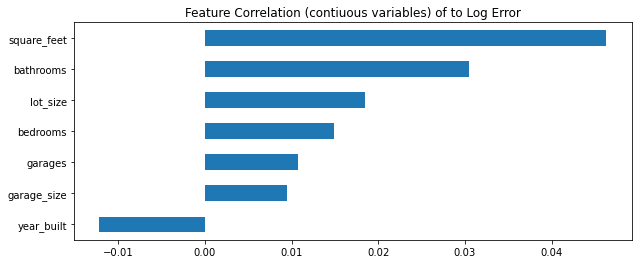

In [14]:
plt.figure(figsize=(10, 4))
# sets the size of the graph
plt.title("Feature Correlation (contiuous variables) of to Log Error")
corr_chart = continuous_features.corrwith(orange_train['log_error']).sort_values().plot.barh()
corr_chart


- square feet, bathrooms, and year built - these 3 move on for modeling

In [15]:
discrete_features

,has_pool,transaction_date,propertycountylandusecode
50705,False,2017-09-08,122
7085,False,2017-02-17,122
4560,False,2017-01-31,122
24504,False,2017-05-16,122
24460,True,2017-05-15,122
...,...,...,...
16131,True,2017-04-06,122
40484,False,2017-07-24,122
7527,True,2017-02-21,122
50318,True,2017-09-07,122


In [16]:
orange_train

,parcelid,bathrooms,bedrooms,square_feet,fips,garages,garage_size,lot_size,has_pool,propertycountylandusecode,propertylandusetypeid,year_built,log_error,transaction_date,county,latitude,longitude
50705,14414316.0,3.0,4.0,2104.0,6059.0,2.0,441.0,4275.0,False,122,261.0,1977.0,0.019273,2017-09-08,orange,33.554803,-117.701673
7085,14037285.0,1.5,3.0,1032.0,6059.0,2.0,441.0,6000.0,False,122,261.0,1962.0,-0.013230,2017-02-17,orange,33.738875,-118.016219
4560,14496831.0,3.0,3.0,1299.0,6059.0,2.0,440.0,3750.0,False,122,261.0,1986.0,-0.000039,2017-01-31,orange,33.651782,-117.576876
24504,14473040.0,2.0,4.0,2109.0,6059.0,2.0,475.0,8449.0,False,122,261.0,1966.0,0.078144,2017-05-16,orange,33.599907,-117.664683
24460,14057077.0,2.0,5.0,1982.0,6059.0,2.0,506.0,6000.0,True,122,261.0,1964.0,-0.019793,2017-05-15,orange,33.677214,-117.952371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16131,14144893.0,2.5,4.0,2655.0,6059.0,2.0,493.0,19680.0,True,122,261.0,1964.0,-0.000091,2017-04-06,orange,33.894337,-117.939625
40484,14076657.0,2.0,3.0,1439.0,6059.0,2.0,460.0,5000.0,False,122,261.0,1971.0,-0.055627,2017-07-24,orange,33.714278,-117.942550
7527,13931397.0,2.0,3.0,1889.0,6059.0,2.0,400.0,8400.0,True,122,261.0,1955.0,0.011196,2017-02-21,orange,33.798431,-117.951018
50318,14036755.0,2.0,4.0,1454.0,6059.0,2.0,451.0,6000.0,True,122,261.0,1963.0,-0.057559,2017-09-07,orange,33.732223,-118.018982


In [17]:
import plotly.express as px

Text(0.5, 1.0, 'Land Code w/Cont.')

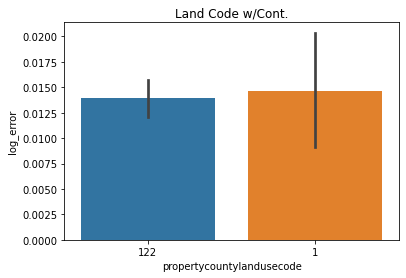

In [18]:
sns.barplot(data=orange_train, x='propertycountylandusecode', y='log_error')
plt.title("Land Code w/Cont.")

In [19]:
orange_train.propertycountylandusecode.value_counts()

122    6863
1       505
Name: propertycountylandusecode, dtype: int64

Text(0.5, 1.0, 'Square Footage Correlation (Grouped by Bin) to Log Error')

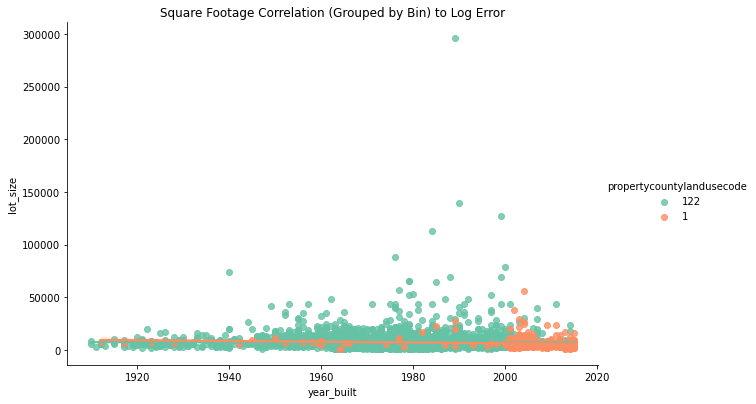

In [20]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.lmplot(x='year_built', y='lot_size', data=orange_train, scatter=True, hue='propertycountylandusecode', col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by Bin) to Log Error")

In [21]:
#log error for square foot less than 2000 in 122 is problem
#1960
#with 2-4 br

In [22]:
(orange_train.where(orange_train.propertycountylandusecode == '122')).describe()

,parcelid,bathrooms,bedrooms,square_feet,fips,garages,garage_size,lot_size,propertylandusetypeid,year_built,log_error,latitude,longitude
count,6.863000e+03,6863.000000,6863.000000,6863.000000,6863.0,6863.000000,6863.000000,6863.000000,6863.0,6863.000000,6863.000000,6863.000000,6863.000000
mean,1.418608e+07,2.375127,3.418330,1976.051435,6059.0,1.856040,470.832872,7157.344019,261.0,1971.848754,0.013903,33.721631,-117.837948
std,1.981944e+05,0.720478,0.801846,773.033827,0.0,0.576395,158.169884,6544.453894,0.0,16.273032,0.076180,0.126055,0.135150
min,1.383453e+07,1.000000,1.000000,653.000000,6059.0,0.000000,0.000000,540.000000,261.0,1910.000000,-0.309399,33.393644,-118.111451
25%,1.401427e+07,2.000000,3.000000,1392.000000,6059.0,2.000000,420.000000,5000.000000,261.0,1961.000000,-0.018369,33.632048,-117.950374
50%,1.418736e+07,2.000000,3.000000,1804.000000,6059.0,2.000000,460.000000,6458.000000,261.0,1971.000000,0.007192,33.732138,-117.856701
75%,1.437103e+07,3.000000,4.000000,2398.000000,6059.0,2.000000,520.000000,7902.000000,261.0,1984.000000,0.035526,33.824317,-117.714816
max,1.476274e+07,5.000000,5.000000,5494.000000,6059.0,14.000000,4251.000000,296208.000000,261.0,2015.000000,0.491767,33.945897,-117.554636


In [23]:
(orange_train.where(orange_train.propertycountylandusecode == '1')).describe()

,parcelid,bathrooms,bedrooms,square_feet,fips,garages,garage_size,lot_size,propertylandusetypeid,year_built,log_error,latitude,longitude
count,5.050000e+02,505.000000,505.000000,505.000000,505.0,505.000000,505.000000,505.000000,505.0,505.000000,505.000000,505.000000,505.000000
mean,1.427168e+07,3.271287,3.772277,2861.055446,6059.0,2.000000,514.097030,6201.013861,261.0,2003.653465,0.014645,33.683871,-117.779306
std,1.908072e+05,0.808970,0.699790,830.189647,0.0,0.345033,118.694538,4531.934806,0.0,12.378966,0.067993,0.144146,0.131958
min,1.383882e+07,1.000000,2.000000,902.000000,6059.0,0.000000,0.000000,1027.000000,261.0,1912.000000,-0.266302,33.423443,-118.107041
25%,1.415672e+07,2.500000,3.000000,2283.000000,6059.0,2.000000,428.000000,3812.000000,261.0,2003.000000,-0.014907,33.550964,-117.869508
50%,1.432801e+07,3.000000,4.000000,2777.000000,6059.0,2.000000,466.000000,5232.000000,261.0,2005.000000,0.008090,33.681750,-117.770978
75%,1.445362e+07,4.000000,4.000000,3451.000000,6059.0,2.000000,611.000000,7187.000000,261.0,2009.000000,0.033477,33.786391,-117.643618
max,1.476217e+07,5.000000,5.000000,5438.000000,6059.0,4.000000,889.000000,56280.000000,261.0,2015.000000,0.497845,33.935358,-117.576924


In [24]:
from sklearn.cluster import KMeans
import sklearn.preprocessing

In [25]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(orange_train[['bathrooms','square_feet']])
# inserts the 4 selected features into the scaler

orange_train[['scalbathrooms','scalsquare_feet']] = scaler.transform(orange_train[['bathrooms', 'square_feet']])

In [26]:
X = orange_train[['scalbathrooms', 'scalsquare_feet']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

kmeans.predict(X)

orange_train['cluster'] = kmeans.predict(X)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

,scalbathrooms,scalsquare_feet
0,0.798717,0.659187
1,0.258336,0.181973
2,0.519531,0.460576
3,0.056990,0.098303
4,0.404053,0.296922


Text(0.5, 1.0, 'Change in inertia as k increases')

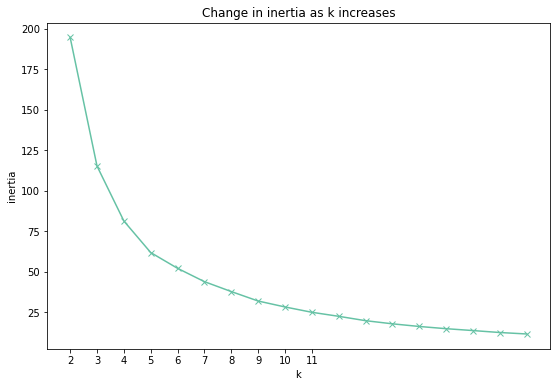

In [27]:
plt.figure(figsize=(9, 6))
pd.Series({k: KMeans(k).fit(X).inertia_ for k in range(2, 20)}).plot(marker='x')
plt.xticks(range(2, 12))
plt.xlabel('k')
plt.ylabel('inertia')
plt.title('Change in inertia as k increases')

In [28]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(orange_validate[['bathrooms', 'square_feet']])
# inserts the 4 selected features into the scaler

orange_validate[['scalbathrooms', 'scalsquare_feet']] = scaler.transform(orange_validate[['bathrooms', 'square_feet']])

In [29]:
X = orange_validate[['scalbathrooms', 'scalsquare_feet']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

kmeans.predict(X)

orange_validate['cluster'] = kmeans.predict(X)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

,scalbathrooms,scalsquare_feet
0,0.056439,0.099125
1,0.403448,0.287123
2,0.505037,0.461890
3,0.782751,0.645242
4,0.259159,0.175502


In [30]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(orange_test[['bathrooms','square_feet']])
# inserts the 4 selected features into the scaler

orange_test[['scalbathrooms', 'scalsquare_feet']] = scaler.transform(orange_test[['bathrooms', 'square_feet']])

In [31]:
X = orange_test[['scalbathrooms',  'scalsquare_feet']]

kmeans = KMeans(n_clusters=5)
kmeans.fit(X)

kmeans.predict(X)

orange_test['cluster'] = kmeans.predict(X)

centroids = pd.DataFrame(kmeans.cluster_centers_, columns=X.columns)
centroids

,scalbathrooms,scalsquare_feet
0,0.791005,0.665695
1,0.415370,0.295407
2,0.258168,0.181835
3,0.502735,0.462747
4,0.059840,0.102443


In [32]:
orange_train

,parcelid,bathrooms,bedrooms,square_feet,fips,garages,garage_size,lot_size,has_pool,propertycountylandusecode,propertylandusetypeid,year_built,log_error,transaction_date,county,latitude,longitude,scalbathrooms,scalsquare_feet,cluster
50705,14414316.0,3.0,4.0,2104.0,6059.0,2.0,441.0,4275.0,False,122,261.0,1977.0,0.019273,2017-09-08,orange,33.554803,-117.701673,0.500,0.299731,4
7085,14037285.0,1.5,3.0,1032.0,6059.0,2.0,441.0,6000.0,False,122,261.0,1962.0,-0.013230,2017-02-17,orange,33.738875,-118.016219,0.125,0.078290,3
4560,14496831.0,3.0,3.0,1299.0,6059.0,2.0,440.0,3750.0,False,122,261.0,1986.0,-0.000039,2017-01-31,orange,33.651782,-117.576876,0.500,0.133444,4
24504,14473040.0,2.0,4.0,2109.0,6059.0,2.0,475.0,8449.0,False,122,261.0,1966.0,0.078144,2017-05-16,orange,33.599907,-117.664683,0.250,0.300764,1
24460,14057077.0,2.0,5.0,1982.0,6059.0,2.0,506.0,6000.0,True,122,261.0,1964.0,-0.019793,2017-05-15,orange,33.677214,-117.952371,0.250,0.274530,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16131,14144893.0,2.5,4.0,2655.0,6059.0,2.0,493.0,19680.0,True,122,261.0,1964.0,-0.000091,2017-04-06,orange,33.894337,-117.939625,0.375,0.413551,4
40484,14076657.0,2.0,3.0,1439.0,6059.0,2.0,460.0,5000.0,False,122,261.0,1971.0,-0.055627,2017-07-24,orange,33.714278,-117.942550,0.250,0.162363,1
7527,13931397.0,2.0,3.0,1889.0,6059.0,2.0,400.0,8400.0,True,122,261.0,1955.0,0.011196,2017-02-21,orange,33.798431,-117.951018,0.250,0.255319,1
50318,14036755.0,2.0,4.0,1454.0,6059.0,2.0,451.0,6000.0,True,122,261.0,1963.0,-0.057559,2017-09-07,orange,33.732223,-118.018982,0.250,0.165462,1


Text(0.5, 1.0, 'Square Footage Correlation (Grouped by Bin) to Log Error')

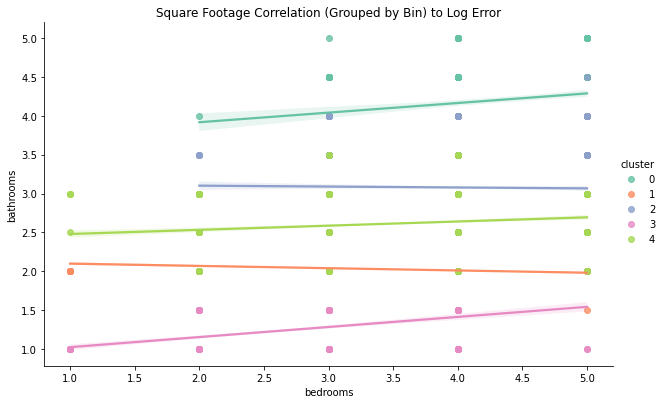

In [33]:
sns.set_palette('Set2', 20)
# sets colors for graph
sns.lmplot(x='bedrooms', y='bathrooms', data=orange_train, scatter=True, hue='cluster', col=None, height=5.5, aspect=8.7/5.5)
plt.title("Square Footage Correlation (Grouped by Bin) to Log Error")

Text(0.5, 1.0, 'Land Code w/Cont.')

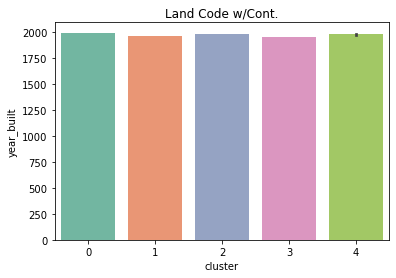

In [34]:
sns.barplot(data=orange_train, x='cluster', y='year_built')
plt.title("Land Code w/Cont.")

In [35]:
orange_train['cluster'] = orange_train.cluster.astype('object')
orange_validate['cluster'] = orange_validate.cluster.astype('object')
orange_test['cluster'] = orange_test.cluster.astype('object')

STARTHERE

In [36]:
afavlj

NameError: name 'afavlj' is not defined

In [ ]:
dummy_train = pd.get_dummies(orange_train[['propertycountylandusecode', 'cluster']])
dummy_validate = pd.get_dummies(orange_validate[['propertycountylandusecode', 'cluster']])
dummy_test = pd.get_dummies(orange_test[['propertycountylandusecode', 'cluster']])

In [ ]:
dummy_train

In [ ]:
X_train = orange_train[['square_feet','bedrooms', 'bathrooms', 'year_built']]
y_train = orange_train[['log_error']]

X_validate = orange_validate[['square_feet','bedrooms', 'bathrooms', 'year_built']]
y_validate = orange_validate[['log_error']]

X_test = orange_test[['square_feet','bedrooms', 'bathrooms', 'year_built']]
y_test = orange_test[['log_error']]

In [ ]:
scaler = sklearn.preprocessing.MinMaxScaler()
scaler.fit(X_train[['bedrooms', 'bathrooms', 'year_built', 'square_feet']])

In [ ]:
v = scaler.transform(X_train[['bedrooms', 'bathrooms', 'year_built', 'square_feet']]) 
v1 = scaler.transform(X_validate[['bedrooms', 'bathrooms', 'year_built', 'square_feet']]) 
v2 = scaler.transform(X_test[['bedrooms', 'bathrooms', 'year_built', 'square_feet']]) 

In [ ]:
v = pd.DataFrame(data = v)
v1 = pd.DataFrame(data = v1)
v2 = pd.DataFrame(data = v2)

In [ ]:
v.index = X_train.index
v1.index = X_validate.index
v2.index = X_test.index

In [ ]:
X_train = pd.concat([X_train, v], axis=1)
X_validate = pd.concat([X_validate, v1], axis=1)
X_test = pd.concat([X_test, v2], axis=1)

In [ ]:
X_train = X_train.drop(columns=['bedrooms', 'bathrooms', 'year_built', 'square_feet'])
y_train = y_train[['log_error']]

X_validate = X_validate.drop(columns=['bedrooms', 'bathrooms', 'year_built', 'square_feet'])
y_validate = y_validate[['log_error']]

X_test = X_test.drop(columns=['bedrooms', 'bathrooms', 'year_built', 'square_feet'])
y_test = y_test[['log_error']]

In [ ]:
X_train = pd.concat([X_train, dummy_train], axis=1)
X_validate = pd.concat([X_validate, dummy_validate], axis=1)
X_test = pd.concat([X_test, dummy_test], axis=1)

In [ ]:
X_train

In [ ]:
y_train['pred_mean'] = y_train.log_error.mean()
y_validate['pred_mean'] = y_validate.log_error.mean()

rmse_train = mean_squared_error(y_train.log_error, y_train.pred_mean)**(1/2)
rmse_validate = mean_squared_error(y_validate.log_error, y_validate.pred_mean)**(1/2)

print("Baseline RMSE\nTrain/In-Sample: ", round(rmse_train, 4)), 
print("Baseline RMSE\nValidate/Out-of-Sample: ", round(rmse_validate, 4))

In [ ]:
lm = LinearRegression(normalize=True)

lm.fit(X_train, y_train.log_error)

y_train['value_predict_lm'] = lm.predict(X_train)

rmse_train = mean_squared_error(y_train.log_error, y_train.value_predict_lm)**(1/2)


In [ ]:
X_validate

In [ ]:
y_validate['value_predict_lm'] = lm.predict(X_validate)
rmse_validate = mean_squared_error(y_validate.log_error, y_validate.value_predict_lm)**(1/2)


printmd("**OLS Linear Regression Performance**")
print("---------------------------------------")
print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", round(rmse_train, 4))
print("---------------------------------------")
print("RMSE for OLS using LinearRegression\nValidation/Out-of-Sample: ", round(rmse_validate, 4))

In [ ]:
lars = LassoLars(alpha=1.0)

lars.fit(X_train, y_train.log_error)

y_train['pred_lars'] = lars.predict(X_train)

rmse_train = mean_squared_error(y_train.log_error, y_train.pred_lars)**(1/2)

y_validate['pred_lars'] = lars.predict(X_validate)
rmse_validate = mean_squared_error(y_validate.log_error, y_validate.pred_lars)**(1/2)

printmd("**LARS Performance**")
print("---------------------------------------")
print("RMSE for Lars\nTraining/In-Sample: ", round(rmse_train, 4))
print("---------------------------------------")
print("RMSE for Lars\nOut-of-Sample: ", round(rmse_validate, 4))

In [ ]:
pf = PolynomialFeatures(degree=2)
# creates polynomial features to use in model with degree of 3

X_train_degree3 = pf.fit_transform(X_train)
# fit and transform X_train_scaled

X_validate_degree3 = pf.transform(X_validate)
X_test_degree3 = pf.transform(X_test)
# transform X_validate_scaled & X_test_scaled

In [ ]:
lm3 = LinearRegression(normalize=True)
# creates linear regression model prior to fitting with new polynomial features

lm3.fit(X_train_degree3, y_train.log_error)
# fit and transform polynomial features and target

y_train['value_pred_lm3'] = lm3.predict(X_train_degree3)
# predictions calculated on train

rmse_train = mean_squared_error(y_train.log_error, y_train.value_pred_lm3)**(1/2)
# computes rmse with train

y_validate['value_pred_lm3'] = lm3.predict(X_validate_degree3)
rmse_validate = mean_squared_error(y_validate.log_error, y_validate.value_pred_lm3)**(1/2)
# computes predictions/rmse with validate

printmd("**Polynomial Regression Model Performance**")
print("---------------------------------------")
print("RMSE for Polynomial Model \nTraining/In-Sample: ", round(rmse_train, 4)),
print("---------------------------------------")
print("RMSE for Polynomial Model, \nValidation/Out-of-Sample: ", round(rmse_validate, 4))

In [ ]:
X_train